# Cox-Time

In this notebook we will train the [Cox-Time method](http://jmlr.org/papers/volume20/18-424/18-424.pdf).
We will use the METABRIC data sets as an example

A more detailed introduction to the `pycox` package can be found in [this notebook](https://nbviewer.jupyter.org/github/havakv/pycox/blob/master/examples/01_introduction.ipynb) about the `LogisticHazard` method.

The main benefit Cox-Time (and the other Cox methods) has over Logistic-Hazard is that it is a continuous-time method, meaning we do not need to discretize the time scale.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.datasets import metabric
from pycox.models import CoxTime
from pycox.models.cox_time import MLPVanillaCoxTime
from pycox.evaluation import EvalSurv

In [2]:
## Uncomment to install `sklearn-pandas`
# ! pip install sklearn-pandas

In [3]:
np.random.seed(1234)
_ = torch.manual_seed(123)

## Dataset

We load the METABRIC data set and split in train, test and validation.

In [4]:
df_train = metabric.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [5]:
df_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,99.333336,0
1,5.284882,9.581043,10.204620,5.664970,1.0,0.0,0.0,1.0,85.940002,95.733330,1
3,6.654017,5.341846,8.646379,5.655888,0.0,0.0,0.0,0.0,66.910004,239.300003,0
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998,56.933334,1
5,5.425826,6.331182,10.455145,5.749053,1.0,1.0,0.0,1.0,70.519997,123.533333,0


## Feature transforms
We have 9 covariates, in addition to the durations and event indicators.

We will standardize the 5 numerical covariates, and leave the binary variables as is. As variables needs to be of type `'float32'`, as this is required by pytorch.

In [6]:
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [7]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

The targets (durations and events) also needs to be arrays of type `'float32'`, and with the `CoxTime.label_transform` we standardize the durations.

In [8]:
labtrans = CoxTime.label_transform()
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))
durations_test, events_test = get_target(df_test)
val = tt.tuplefy(x_val, y_val)

In [9]:
val.shapes()

((305, 9), ((305,), (305,)))

With `TupleTree` (the results of `tt.tuplefy`) we can easily repeat the validation dataset multiple times. This will be useful for reduce the variance of the validation loss, as the validation loss of `CoxTime` is not deterministic.

In [10]:
val.repeat(2).cat().shapes()

((610, 9), ((610,), (610,)))

## Neural net

We create a simple MLP with two hidden layers, ReLU activations, batch norm and dropout. 
The net required by `CoxTime` is slightly different than most of the other methods as it also take `time` and an additional input argument. 
We have therefore crated the `MLPVanillaCoxTime` class that is a suitable version of `tt.practical.MLPVanilla`.
This class also removes the options for setting `out_features` and `output_bias` as they should be `1` and `False`, respectively.

To see the code for the networks call `??MLPVanillaCoxTime`.

In [11]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
batch_norm = True
dropout = 0.1
net = MLPVanillaCoxTime(in_features, num_nodes, batch_norm, dropout)

## Training the model

To train the model we need to define an optimizer. You can choose any `torch.optim` optimizer, but here we instead use one from `tt.optim` as it has some added functionality.
We use the `Adam` optimizer, but instead of choosing a learning rate, we will use the scheme proposed by [Smith 2017](https://arxiv.org/pdf/1506.01186.pdf) to find a suitable learning rate with `model.lr_finder`. See [this post](https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6) for an explanation.

We also set `labtrans` which connects the output nodes of the network the the label transform of the durations. This is only useful for prediction and does not affect the training procedure.

In [12]:
model = CoxTime(net, tt.optim.Adam, labtrans=labtrans)

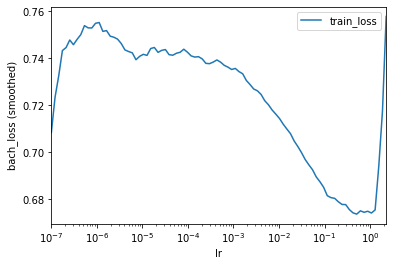

In [13]:
batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=2)
_ = lrfinder.plot()

In [14]:
lrfinder.get_best_lr()

0.050941380148164093

Often, this learning rate is a little high, so we instead set it manually to 0.01

In [15]:
model.optimizer.set_lr(0.01)

We include the `EarlyStopping` callback to stop training when the validation loss stops improving. After training, this callback will also load the best performing model in terms of validation loss.

In [16]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [17]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val.repeat(10).cat())

0:	[0s / 0s],		train_loss: 0.6933,	val_loss: 0.6385
1:	[0s / 0s],		train_loss: 0.6647,	val_loss: 0.6199
2:	[0s / 0s],		train_loss: 0.6206,	val_loss: 0.6070
3:	[0s / 0s],		train_loss: 0.6209,	val_loss: 0.6077
4:	[0s / 0s],		train_loss: 0.6191,	val_loss: 0.5916
5:	[0s / 0s],		train_loss: 0.5963,	val_loss: 0.5833
6:	[0s / 0s],		train_loss: 0.5866,	val_loss: 0.6018
7:	[0s / 0s],		train_loss: 0.5936,	val_loss: 0.6034
8:	[0s / 0s],		train_loss: 0.5827,	val_loss: 0.5987
9:	[0s / 0s],		train_loss: 0.5864,	val_loss: 0.6055
10:	[0s / 0s],		train_loss: 0.5861,	val_loss: 0.6134
11:	[0s / 0s],		train_loss: 0.5712,	val_loss: 0.5782
12:	[0s / 0s],		train_loss: 0.5819,	val_loss: 0.5991
13:	[0s / 0s],		train_loss: 0.5775,	val_loss: 0.5765
14:	[0s / 0s],		train_loss: 0.5685,	val_loss: 0.5881
15:	[0s / 0s],		train_loss: 0.5803,	val_loss: 0.5782
16:	[0s / 0s],		train_loss: 0.5956,	val_loss: 0.5880
17:	[0s / 0s],		train_loss: 0.5657,	val_loss: 0.5825
18:	[0s / 0s],		train_loss: 0.5677,	val_loss: 0.6120
19:

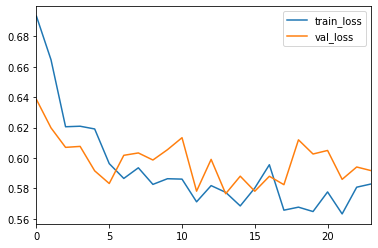

In [18]:
_ = log.plot()

We can get the partial log-likelihood

In [19]:
model.partial_log_likelihood(*val).mean()

-4.855360578086461

## Prediction

For evaluation we first need to obtain survival estimates for the test set.
This can be done with `model.predict_surv` which returns an array of survival estimates, or with `model.predict_surv_df` which returns the survival estimates as a dataframe.

However, as Cox-Time is semi-parametric, we first need to get the non-parametric baseline hazard estimates with `compute_baseline_hazards`. 

Note that for large datasets the `sample` argument can be used to estimate the baseline hazard on a subset.

In [20]:
_ = model.compute_baseline_hazards()

In [21]:
surv = model.predict_surv_df(x_test)

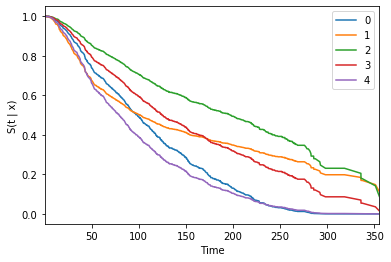

In [22]:
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

Note that because we set `labtrans` in `CoxTime` we get the correct time scale for our predictions.

## Evaluation

We can use the `EvalSurv` class for evaluation the concordance, brier score and binomial log-likelihood. Setting `censor_surv='km'` means that we estimate the censoring distribution by Kaplan-Meier on the test set.

In [23]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [24]:
ev.concordance_td()

0.6746906255297508

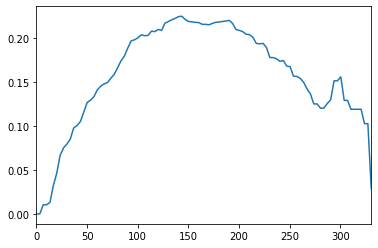

In [25]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.brier_score(time_grid).plot()

In [26]:
ev.integrated_brier_score(time_grid)

0.15931537174591134

In [27]:
ev.integrated_nbll(time_grid)

0.4700909149743365